In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs

# ---------------------
# Define the Convolutional VAE with dynamic dimensions
# ---------------------
class ConvVAE(nn.Module):
    def __init__(self, input_shape=(1,70,70), latent_dim=32):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # -> ~32x35x35
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> ~64x17x17
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),# -> ~128x8x8
            nn.ReLU(True)
        )
        # Compute shape after convs
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out = self.enc_conv(dummy)
            self.conv_shape = conv_out.shape[1:]  # (C, H, W)
            num_features = conv_out.view(1, -1).size(1)

        # Latent mappings
        self.fc_mu = nn.Linear(num_features, latent_dim)
        self.fc_logvar = nn.Linear(num_features, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, num_features)

        # Decoder (transpose convs)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> ~64x16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> ~32x32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # -> ~1x64x64
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar, deterministic=False):
        if deterministic:
            return mu
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, target_shape=(70,70)):
        h = self.fc_dec(z)
        # reshape to conv feature map
        h = h.view(-1, *self.conv_shape)
        x_recon = self.dec_conv(h)
        # resize to original input shape
        x_recon = nn.functional.interpolate(x_recon, size=target_shape, mode='bilinear', align_corners=False)
        return x_recon

    def forward(self, x, deterministic=False):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, deterministic)
        x_recon = self.decode(z, target_shape=(x.size(2), x.size(3)))
        return x_recon, mu, logvar

# ---------------------
# Loss function: ELBO (reconstruction + KL)
# ---------------------
def loss_function(recon_x, x, mu, logvar, recon_weight=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum') * recon_weight
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl, recon_loss, kl

# ---------------------
# Training & Testing with Real and Random Data
# ---------------------
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load real training and test sets
    data = []
    for ii in range(133):
        this_data = np.load(kgs.data_dir + '/full_style_B/model'+str(ii+2)+'.npy')[:,0,:,:]
        data.append(this_data)
    data_np = np.concatenate(data, axis=0)
    print(data_np.shape)
    test_np = np.load(kgs.data_dir + '/train_samples/Style_B/model/model1.npy')[:,0,:,:]
    # Generate a separate random set for extra OOD check
    #N_test2 = 100
    #test2_np = np.random.uniform(1500, 4500, size=(N_test2, 70, 70))
    import glob
    files = glob.glob(kgs.cache_dir_read + 'Style_B/*data*')
    test2_list = []
    for f in files:
        test2_list.append(kgs.dill_load(f)[0].data)
    test2_np = np.stack(test2_list)

    # Normalize to [0,1]
    data_np = (data_np - 1500.0) / 3000.0
    test_np = (test_np - 1500.0) / 3000.0
    test2_np = (test2_np - 1500.0) / 3000.0

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(torch.from_numpy(data_np).unsqueeze(1)), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.from_numpy(test_np).unsqueeze(1)), batch_size=64, shuffle=False)

    # Initialize model and optimizer
    model = ConvVAE(input_shape=(1,70,70), latent_dim=1024).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    epochs = 50
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0
        for (x,) in train_loader:
            x = x.float().to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss, _, _ = loss_function(recon_x, x, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch:2d} Train Loss: {train_loss/len(train_loader.dataset):.6f}")

    # Evaluation on test set
    model.eval()
    total_elbo = 0
    with torch.no_grad():
        for (x,) in test_loader:
            x = x.float().to(device)
            recon_x, mu, logvar = model(x)
            elbo = - (nn.functional.mse_loss(recon_x, x, reduction='sum') + \
                      (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())))
            total_elbo += elbo.item()
    print(f"Avg Test ELBO: {total_elbo/len(test_loader.dataset):.4f}")

    # Example probabilities
    for desc, tensor in [('Test', test_np), ('Train', data_np), ('Random-OOD', test2_np)]:
        sample = torch.from_numpy(tensor[:10]).unsqueeze(1).float().to(device)
        recon_x, mu, logvar = model(sample, deterministic=True)
        elbo_sample = - (nn.functional.mse_loss(recon_x, sample, reduction='sum') + \
                         (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())))
        prob = torch.exp(elbo_sample / (70*70))  # per-pixel scaling
        print(f"{desc} Sample ELBO: {elbo_sample.item():.4f}, Prob: {prob.item():.6f}")

    # ---------------------
    # Prior Sampling
    # ---------------------
    num_prior = 5
    z_samples = torch.randn(num_prior, model.latent_dim, device=device)
    with torch.no_grad():
        prior_imgs = model.decode(z_samples, target_shape=(70,70))
    # Rescale back to velocity units
    prior_phys = prior_imgs * 3000.0 + 1500.0
    print(f"Generated {num_prior} prior samples with shape {prior_phys.shape}")
    # Save samples
    #for i, img in enumerate(prior_phys.squeeze(1)):
    #    np.save(kgs.data_dir + f'/prior_sample_{i}.npy', img.cpu().numpy())
    #print("Prior samples saved to disk.")


(66500, 70, 70)
Epoch  1 Train Loss: 50.092759
Epoch  2 Train Loss: 32.975364
Epoch  3 Train Loss: 31.649112
Epoch  4 Train Loss: 30.994294
Epoch  5 Train Loss: 30.485297
Epoch  6 Train Loss: 30.042029
Epoch  7 Train Loss: 29.603246
Epoch  8 Train Loss: 29.310792
Epoch  9 Train Loss: 29.187072
Epoch 10 Train Loss: 28.975004
Epoch 11 Train Loss: 28.815120


KeyboardInterrupt: 

In [ ]:
p = prior_phys.detach().cpu().numpy()[:,0,:,:]

In [ ]:
import matplotlib.pyplot as plt
for ii in range(p.shape[0]):
    plt.figure();plt.imshow(p[ii,...], cmap='viridis');plt.colorbar()

In [4]:
x=data_np[:,...]
x = np.reshape(x, (x.shape[0],-1))
import cupy as cp
x = cp.array(x)
x = x-cp.mean(x,axis=0)

In [5]:
cov = x.T@x
cov.shape

(4900, 4900)

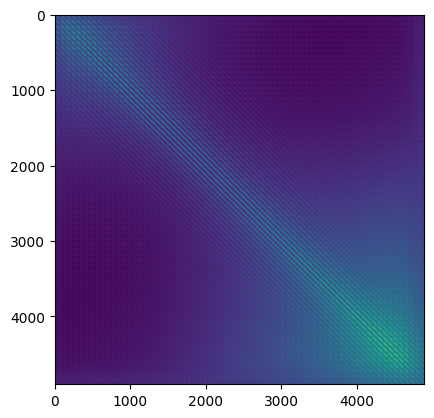

In [8]:
import matplotlib.pyplot as plt
plt.figure();plt.imshow(cov.get())

In [3]:
cp.mean(x,axis=0).shape

(4900,)

In [2]:
import numpy as np

def closest_neighbor_values(A):
    """
    For each element in A, find among its up/down/left/right neighbors
    the one whose value is closest to A[i,j], and store that neighbor's
    value in the output array B.
    """
    A = np.asarray(A)
    m, n = A.shape
    
    # Prepare shifted versions of A; out-of-bounds positions get a large dummy difference
    # so they will never be chosen.
    inf = np.finfo(A.dtype).max
    # shift up
    A_up = np.empty_like(A);   A_up[1:,:] = A[:-1,:];   A_up[0,:] = inf
    # shift down
    A_dn = np.empty_like(A);   A_dn[:-1,:] = A[1:,:];    A_dn[-1,:] = inf
    # shift left
    A_lf = np.empty_like(A);   A_lf[:,1:] = A[:,:-1];   A_lf[:,0] = inf
    # shift right
    A_rt = np.empty_like(A);   A_rt[:,:-1] = A[:,1:];    A_rt[:,-1] = inf

    # Stack all neighbor values and compute absolute differences:
    # shape (m, n, 4)
    neigh_vals = np.stack([A_up, A_dn, A_lf, A_rt], axis=-1)
    diffs      = np.abs(neigh_vals - A[..., np.newaxis])

    # Find index of the closest neighbor along the last axis, then pick its value
    idx_closest = np.argmin(diffs, axis=-1)
    B = np.take_along_axis(neigh_vals, idx_closest[..., np.newaxis], axis=-1)[..., 0]

    return B

# Example
A = np.array([[10, 12, 15],
              [14, 13, 11],
              [ 9, 20, 16]])
A = A.astype(np.float64)
B = closest_neighbor_values(A)
print(B)
# Output might be:
# [[14 13 12]
#  [10 12 11]
#  [14 11 11]]

[[12. 13. 12.]
 [13. 12. 13.]
 [14. 16. 20.]]
